In [ ]:
# ResNet-34 모델 만들기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

In [2]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 (ResNet 논문 기반)
""" VGG-19 코드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# 훈련/테스트 분리: 훈련용 transform_train에 증강 적용, 
# 테스트용 transform_test는 정규화만 적용하여 평가 일관성 유지.
"""
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 데이터 증강 추가 : 4픽셀 패딩 후 32x32 랜덤 크롭
    transforms.RandomHorizontalFlip(),     # 수평 플립 사용.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# CIFAR-10 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

In [3]:
# ResNet-34 모델 로드 및 수정
# VGG-19는 19 레이어(16 conv + 3 fc, 143M 파라미터), 
# ResNet-34는 34 레이어(Basic Block, 21M 파라미터)로 잔차 연결 사용
model = torchvision.models.resnet34(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()   # ResNet-34의 max pooling(3x3, stride 2)은 작은 입력에서 불필요.
                                # nn.Identity()로 대체하여 입력 해상도 유지.
model.fc = nn.Linear(512, 10)
# VGG-19의 classifier[6]는 4096→1000, ResNet-34는 글로벌 평균 풀링 후 fc(512→1000). CIFAR-10(10 클래스)에 맞게 512→10으로 수정.
model.to(device)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 204MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [6]:
# 손실 함수, 옵티마이저, 스케줄러
criterion = nn.CrossEntropyLoss()
""" VGG-19 코드 VGG-19는 lr=0.001로 파인튜닝
optimizer = optim.SGD(vgg_19.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
"""
# ResNet-34는 논문의 CIFAR-10 설정 따라 lr=0.1로 시작. 높은 학습률은 ResNet의 빠른 수렴에 적합.
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32, 48], gamma=0.1)
# 스케줄러 추가: ResNet 논문은 32k, 48k 반복에서 학습률 10배 감소

In [7]:
# 훈련 루프
current_time = time.time()
EPOCH = 15
""" VGG-19 코드
vgg_19_train_losses = []
vgg_19_val_accuracy = []
"""
train_losses, val_accuracy = [], []  # 변수명 일반화 (vgg_19 → model)

In [8]:
for epoch in range(EPOCH):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

[1,   100] loss: 3.525
[1,   200] loss: 2.094
[1,   300] loss: 1.967
Epoch 1: Train Accuracy: 22.99%
[2,   100] loss: 1.764
[2,   200] loss: 1.697
[2,   300] loss: 1.619
Epoch 2: Train Accuracy: 38.48%
[3,   100] loss: 1.548
[3,   200] loss: 1.507
[3,   300] loss: 1.454
Epoch 3: Train Accuracy: 46.05%
[4,   100] loss: 1.392
[4,   200] loss: 1.351
[4,   300] loss: 1.324
Epoch 4: Train Accuracy: 51.60%
[5,   100] loss: 1.262
[5,   200] loss: 1.225
[5,   300] loss: 1.196
Epoch 5: Train Accuracy: 56.65%
[6,   100] loss: 1.129
[6,   200] loss: 1.120
[6,   300] loss: 1.075
Epoch 6: Train Accuracy: 61.33%
[7,   100] loss: 1.011
[7,   200] loss: 0.994
[7,   300] loss: 0.989
Epoch 7: Train Accuracy: 65.22%
[8,   100] loss: 0.908
[8,   200] loss: 0.877
[8,   300] loss: 0.860
Epoch 8: Train Accuracy: 69.05%
[9,   100] loss: 0.823
[9,   200] loss: 0.824
[9,   300] loss: 0.800
Epoch 9: Train Accuracy: 71.79%
[10,   100] loss: 0.749
[10,   200] loss: 0.748
[10,   300] loss: 0.750
Epoch 10: Train Acc

In [9]:
# 모델을 평가 모드로 전환
model.eval()
    correct = 0   # 검증 정확도 계산을 위한 변수 초기화
    total = 0
    with torch.no_grad():        # 그래디언트 계산 비활성화
        for inputs, labels in testloader:   # 테스트 데이터 로더를 통해 데이터 처리
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total    # 검증 정확도 계산 및 저장
    val_accuracy.append(val_acc)
    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")  # 에포크별 검증 정확도 출력
        scheduler.step()               # 학습률 조정

print("Finished Training")         # 훈련 완료 메시지 출력
print(time.time() - current_time)  # 전체 훈련 시간 출력(초 단위)

IndentationError: unexpected indent (3854503856.py, line 3)

In [25]:
# ResNet-50 모델 로드 및 수정
model = torchvision.models.resnet50(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(2048, 10)  # ResNet-50: Bottleneck Block으로 마지막 채널 2048
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentu

In [26]:
# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32, 48], gamma=0.1)

In [ ]:
# 훈련 루프
current_time = time.time()
EPOCH = 15
train_losses, val_accuracy = [], []

for epoch in range(EPOCH):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_accuracy.append(val_acc)
    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")
    
    scheduler.step()  # 학습률 조정

print("Finished Training")
print(time.time() - current_time)

[1,   100] loss: 2.725
[1,   200] loss: 2.080


ModuleNotFoundError: No module named 'tensorflow'


--- Training ResNet-34 ---
Epoch 1: Train Loss=1.4155, Acc=0.4843 | Test Loss=1.1098, Acc=0.6059
Epoch 2: Train Loss=0.8427, Acc=0.7053 | Test Loss=0.7549, Acc=0.7397
Epoch 3: Train Loss=0.6001, Acc=0.7924 | Test Loss=0.7462, Acc=0.7486
Epoch 4: Train Loss=0.4406, Acc=0.8469 | Test Loss=0.6561, Acc=0.7837
Epoch 5: Train Loss=0.3277, Acc=0.8868 | Test Loss=0.6149, Acc=0.8052
Epoch 6: Train Loss=0.2314, Acc=0.9207 | Test Loss=0.7212, Acc=0.7896
Epoch 7: Train Loss=0.1751, Acc=0.9390 | Test Loss=0.7189, Acc=0.7994
Epoch 8: Train Loss=0.1240, Acc=0.9573 | Test Loss=0.7188, Acc=0.8076
Epoch 9: Train Loss=0.0989, Acc=0.9656 | Test Loss=0.7187, Acc=0.8149
Epoch 10: Train Loss=0.0789, Acc=0.9730 | Test Loss=0.7847, Acc=0.8157

--- Training Plain-34 ---
Epoch 1: Train Loss=1.8429, Acc=0.2960 | Test Loss=1.8208, Acc=0.3532
Epoch 2: Train Loss=1.5221, Acc=0.4377 | Test Loss=1.5266, Acc=0.4481
Epoch 3: Train Loss=1.3014, Acc=0.5279 | Test Loss=1.2334, Acc=0.5575
Epoch 4: Train Loss=1.1158, Acc=0.

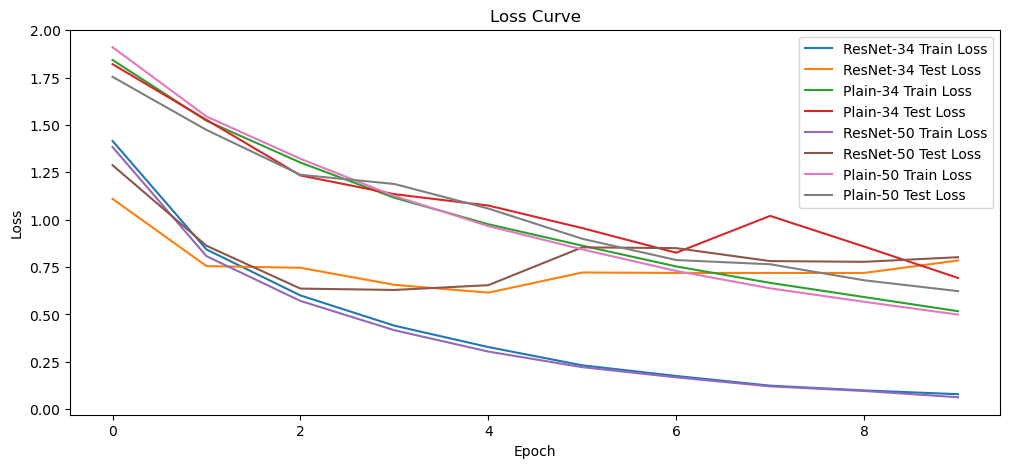

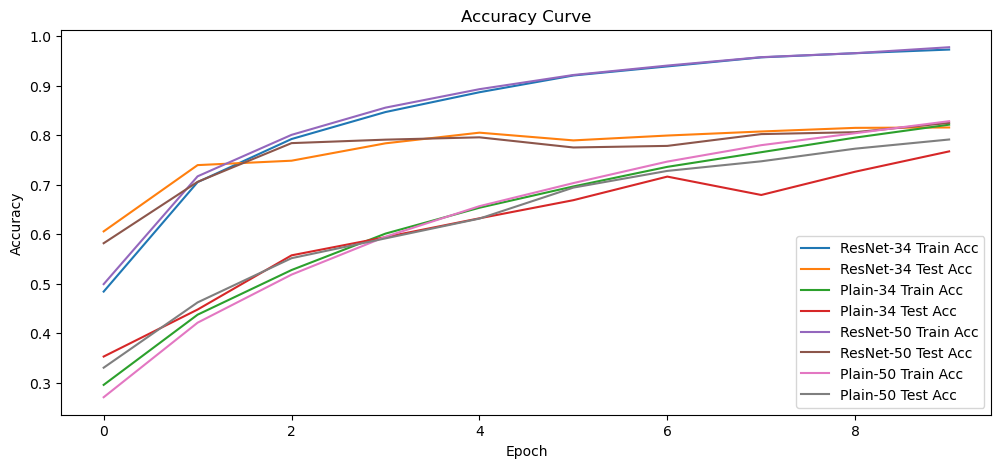

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import copy
import time


# -------------------------------
# 1. BasicBlock 정의 (Plain vs ResNet)
# -------------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, use_skip=True):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.use_skip = use_skip  # True면 ResNet, False면 PlainNet

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        if self.use_skip:  # ResNet
            out += identity
        return self.relu(out)


# -------------------------------
# 2. ResNet/PlainNet 생성 함수
# -------------------------------
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, use_skip=True):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1, use_skip=use_skip)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, use_skip=use_skip)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, use_skip=use_skip)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, use_skip=use_skip)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride, use_skip):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, use_skip))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, use_skip=use_skip))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# ResNet34 / ResNet50 layers 구성
def ResNet34(num_classes=10, use_skip=True):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, use_skip=use_skip)

def ResNet50(num_classes=10, use_skip=True):
    # 실제는 Bottleneck block 필요하지만 비교를 위해 BasicBlock 단순화
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, use_skip=use_skip)


# -------------------------------
# 3. 학습 루프
# -------------------------------
def train_model(model, trainloader, testloader, criterion, optimizer, device, num_epochs=10):
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # 평가
        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        test_loss /= total
        test_acc = correct / total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Test Loss={test_loss:.4f}, Acc={test_acc:.4f}")

    return history


# -------------------------------
# 4. 데이터셋 & 학습 실행
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

models = {
    "ResNet-34": ResNet34().to(device),
    "Plain-34": ResNet34(use_skip=False).to(device),
    "ResNet-50": ResNet50().to(device),
    "Plain-50": ResNet50(use_skip=False).to(device),
}

criterion = nn.CrossEntropyLoss()
histories = {}
for name, model in models.items():
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    print(f"\n--- Training {name} ---")
    histories[name] = train_model(model, trainloader, testloader, criterion, optimizer, device, num_epochs=10)


# -------------------------------
# 5. 그래프 비교
# -------------------------------
plt.figure(figsize=(12,5))
for name, history in histories.items():
    plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.plot(history["test_loss"], label=f"{name} Test Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for name, history in histories.items():
    plt.plot(history["train_acc"], label=f"{name} Train Acc")
    plt.plot(history["test_acc"], label=f"{name} Test Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
"""
회고
처음에 50에폭으로 돌려 보려다가 중간에 사고가 있어서 많은 분석을 못해서 아쉽다.
바이브 코딩을 하다보니 잘 모르는 내가 답답하다.
좀더 코딩에 대해서 알고 싶은 마음이 생겼다.
"""